<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Loading-features" data-toc-modified-id="Loading-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading features</a></span></li><li><span><a href="#Additional-preprocessing" data-toc-modified-id="Additional-preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Additional preprocessing</a></span></li><li><span><a href="#Training-model-and-making-predictions" data-toc-modified-id="Training-model-and-making-predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training model and making predictions</a></span></li><li><span><a href="#Plotting-results" data-toc-modified-id="Plotting-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plotting results</a></span></li></ul></div>

# Overview

In this step of the pipeline, we train our **Logistic Regression** binary classifier on the data and test its performance.

We measure the model performance using **accuracy**, i.e., the fraction of matches in which the model predicts the correct winner. The model accuracy is ~84% at minute 24. Included at the bottom of this notebook is a plot of model performance.

We note that performance worsens for longer matches. One possible explanation for this may be that longer matches have greater balance between teams. For example, items that can be upgraded only have three tiers; once upgraded to the third tier, the item is in its final state and can no longer be improved.
- A possible next step would be to test this and similar item-related hypotheses by analyzing data on item upgrades, e.g., at what minute in the game do teams (on average) finish upgrading their items?

# Imports

In [67]:
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy import interp

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from lib import feature_calculators
from importlib import reload
reload(feature_calculators);

LOG_LEVEL = 'Off'

# Loading features

In [49]:
fin = 'lolwinner_data.npz'

df = np.load(fin)

duration = df['duration']

**Filter matches**. Retain only matches that we actually care about (e.g., exclude matches that end in surrender)

In [50]:
# Min and max duration in minutes
min_duration = 20
max_duration = 60

considered_matches = np.where(
    (duration / 60 >= min_duration) &
    (duration / 60 <= max_duration)
    )[0]

In [51]:
total_gold = df['total_gold'][considered_matches]
winners = Y_all = df['winners'][considered_matches]
versions = df['versions'][considered_matches]
champions = df['champions'][considered_matches]
player_tiers = df['player_tiers'][considered_matches]
num_frames = df['num_frames'][considered_matches]
kills = df['kills'][considered_matches]
buildings = df['buildings'][considered_matches]
monsters = df['monsters'][considered_matches]

gold_diff = total_gold[:, :, 2]

# Additional preprocessing

Here, we scale gold and create a feature tensor

**Set of features**

We use four features:

|Feature | Description | Dimension |
|--- | --- | ---
|`gold_diff` | Difference in total accumulated gold between Blue and Red | `(num_samples, max_frames)`
|`kills` | Difference in kills between Blue and Red | `(num_samples, max_frames)`
|`buildings` | Difference in buildings destroyed (for five building types) between Blue and Red | `(num_samples, max_frames, 5)`
|`monsters` | Difference in elite monsters destroyed (for seven monster types) between Blue and Red | `(num_samples, max_frames, 7)`

where

`num_samples` is the number of matches in our data set and

`max_frames` is the max number of frames across samples (i.e., longest duration in minutes)

**Scaling gold and combining features into single tensor**

- We perform min-max scaling to `gold_diff` to the range `[-1,1]`.

- For ease of use in model, we combine the four features into a single tensor with dimension

    `(num_samples, max_frames, 14 = 1 + 1 + 5 + 7)`

In [66]:
gold_diff_rescaled = feature_calculators.rescale_tensor(gold_diff)
gold_diff_reshape = gold_diff.reshape((gold_diff.shape[0], gold_diff.shape[1], 1))
kills_reshape = kills.reshape((kills.shape[0], kills.shape[1], 1))
X_all = np.concatenate((gold_diff_reshape, kills_reshape, buildings, monsters), axis=2)

print(gold_diff_reshape.shape)
print(kills_reshape.shape)
print(buildings.shape)
print(monsters.shape)
print(X_all.shape)

(54494, 72, 1)
(54494, 72, 1)
(54494, 72, 5)
(54494, 72, 7)
(54494, 72, 14)


# Training model and making predictions

We train a **Logistic Regression** model with **L2 regularization**. The data is divided into train / cross-validation / test sets as follows:
- To reduce variance from selection of test set, perform 5-fold split of data into a (training + CV) set and a test set
- To optimize regularization hyperparameter, perform 5-fold cross-validation within (training + CV) set

In [58]:
def run_logistic_regression(X_train, Y_train, X_test, cv = 5):
    """runs logistic regression

    returns accuracy on training set, and predictions
    """
    model = LogisticRegressionCV(cv = cv)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = round(model.score(X_train, Y_train) * 100, 2)
    Y_pred_prob = model.predict_proba(X_test)
    return accuracy, Y_pred, Y_pred_prob, model.coef_

In [ ]:
# minutes in game to analyze
start = 0
end = 40

# how many prior minutes to include
trailing_window = 4

# seed for RNG
seed = 42

auc_by_frame = []
acc_train_by_frame = []
acc_test_by_frame = []
N_by_frame = []
coef = []

#base_fpr = np.linspace(0, 1, 101)

for frame in range(start, end):

    earliest_frame = max(0, frame - trailing_window)

    # filter out matches that have ended by this minute
    matches = np.where((num_frames > frame))[0]

    X = X_all[matches][:, earliest_frame:frame + 1, ]

    X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

    Y = Y_all[matches]
    
    kf = KFold(n_splits = 5)

    try:
        
        cv_auc = []
        cv_acc_train = []
        cv_acc_test = []
        cv_coef = []
        
        for train_index, test_index in kf.split(X):

            train_X = X[train_index]
            train_Y = Y[train_index]

            test_X = X[test_index]
            test_Y = Y[test_index]

            acc_train, Y_pred, Y_pred_prob, model_coef = run_logistic_regression(
                train_X, train_Y, test_X, cv=5)

            cv_coef.append(model_coef)

            Y_pred_prob = Y_pred_prob[:, 1]
            acc_test = accuracy_score(test_Y, Y_pred) * 100
    #         fpr, tpr, thresholds = metrics.roc_curve(
    #             test_Y, Y_pred_prob, pos_label=1)
    #         tpr = interp(base_fpr, fpr, tpr)
    #         tpr[0] = 0.0
            auc = roc_auc_score(test_Y, Y_pred_prob)
            print(
                'frame: %d, train: %0.2f, test: %0.2f, AUC: %0.2f, N: %d\n' %
                (frame, acc_train, acc_test, auc, len(X)),
                end='')
            
            cv_auc.append(auc)
            cv_acc_train.append(acc_train)
            cv_acc_test.append(acc_test)

        auc_by_frame.append(np.mean(cv_auc))
        acc_train_by_frame.append(np.mean(cv_acc_train))
        acc_test_by_frame.append(np.mean(cv_acc_test))
        N_by_frame.append(len(X))
        coef.append(np.mean(cv_coef,axis=1))

    except:

            print('frame: ', frame, '...issue')

coef = np.array([np.array(x[0]) for x in coef])

# Plotting results

**The model has a peak test accuracy of ~84% at minute 24.**

To improve *early-game* performance, we could incorporate prior player histories, e.g., average win rate over last 100 matches by each player, for the champion (character) that they have selected

To improve *late-game* performance, we could consider:
- **Additional features**. Examples: interaction terms between features, new features such as champions (characters) chosen
- **Additional model complexity**. Example: hierarchical model that condition predictions based on which buildings have been destroyed

Rationale for using accuracy as performance metric: 
- **Balanced data set**. Roughly 50/50 between Blue wins and Red wins
    - Interesting that Blue wins with slightly higher frequency (this is a well-known phenomenon among the League of Legends player community)
- **Symmetry of problem**. We are interested in predicting *winners*, irrespective of which team actually won

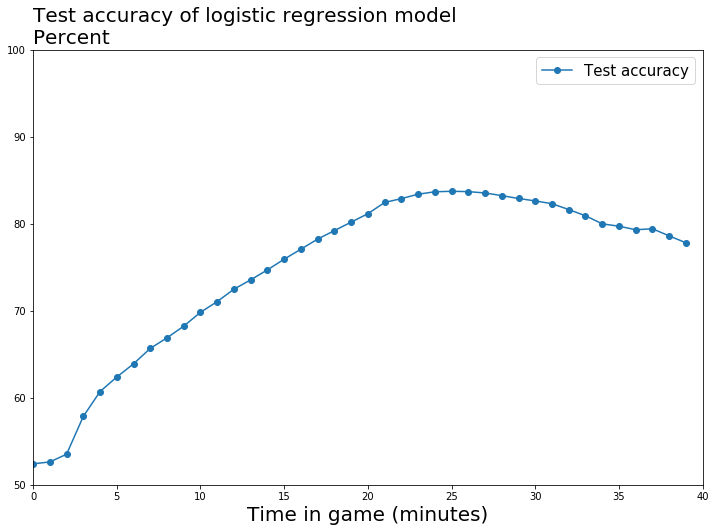

In [85]:
fig, ax = plt.subplots(figsize=(12,8))
#plt.plot(np.array(auc_by_frame)*100,label='AUC',marker='o')
#plt.plot(acc_train_by_frame,label='Train accuracy',marker='o')
plt.plot(acc_test_by_frame,label='Test accuracy',marker='o')
plt.legend(fontsize=15)
plt.ylim(50,100)
plt.xlim(0,40)
plt.xlabel('Time in game (minutes)',fontsize=20)
plt.title('Test accuracy of logistic regression model\nPercent',loc='left',fontsize=20);